In [2]:
import torch
DATA = 'CIFAR'
prefix = 'cifar_dnn2_'
traing = True
epochs = 400
batch_size = 64
leaks_loss = None
print(torch.cuda.get_device_name(0))

Tesla V100-SXM2-16GB


In [3]:
import os
from google.colab import drive

drive.mount('/content/gdrive')
root_path = '/content/gdrive/MyDrive/Colab Notebooks/BinarizeLocalize/'

Mounted at /content/gdrive


In [4]:
pip install import-ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp37-none-any.whl size=2976 sha256=71cd3023bc5fee68b4b390f6f7e9c5d8195f5ce88846517b1298abeacb032779
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [5]:
import import_ipynb
os.chdir(root_path + 'library')
Call_Template = True
%run Template.ipynb

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


##Fetching the dataset and preparing train, validation and test data loaders

In [6]:
(trainSet, validSet, checkSet, testSet,
 trainSetGPU, validSetGPU, checkSetGPU) = load_data_to_gpu()
print(len(trainSet), len(validSet), len(checkSet), len(testSet))

Files already downloaded and verified
Files already downloaded and verified



50000 7000 3000 10000


##Visualising the data

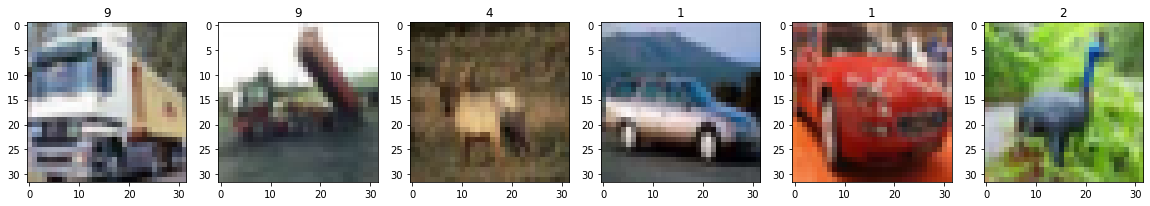

In [7]:
plot_samples(trainSet, None)

In [8]:
class Network(Model):
    def __init__(self):
        super(Network, self).__init__()
        # at client
        self.feature0 = nn.Sequential(
            BinaryConv2d(3, 64, 3, 1, 1), #32
            nn.BatchNorm2d(64),
            BinaryTanh(),
            nn.MaxPool2d(2), #16
            #nn.Dropout(0.1),

            BinaryConv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            BinaryRelu(),
        )
        self.feature1 = nn.Sequential(
            nn.MaxPool2d(2), #8
            nn.Dropout(0.1),            
        )
        # at server
        self.feature2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2), #4
            nn.Dropout(0.5),
            
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2), #2
            nn.Dropout(0.5),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2), #1
            nn.Dropout(0.5),
        )
        self.classifier = nn.Sequential(
            nn.Linear(1 * 512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 1000),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1000, 10)
        )

##Defining model object, loss function and optimiser

In [9]:
(model, criterion, dataleaks, optimizer) = init_training(Network(), 0.0001)

##Training and Validation

In [10]:
(trainLoss, validLoss, leaksLoss, accuracyList) = train_model(1)

Saving the model state dictionary for Epoch: 1 with Validation loss: 1.89214075 and Accuracy: 30.54%
Saving the model state dictionary for Epoch: 2 with Validation loss: 1.57261479 and Accuracy: 41.27%
Saving the model state dictionary for Epoch: 4 with Validation loss: 1.45763695 and Accuracy: 47.10%
Saving the model state dictionary for Epoch: 5 with Validation loss: 1.29275262 and Accuracy: 53.00%
Saving the model state dictionary for Epoch: 6 with Validation loss: 1.26658499 and Accuracy: 54.47%
Saving the model state dictionary for Epoch: 11 with Validation loss: 1.22219694 and Accuracy: 56.84%
Saving the model state dictionary for Epoch: 13 with Validation loss: 1.17216516 and Accuracy: 59.17%
Saving the model state dictionary for Epoch: 15 with Validation loss: 1.08294129 and Accuracy: 62.57%
Saving the model state dictionary for Epoch: 16 with Validation loss: 1.03025222 and Accuracy: 63.94%
Saving the model state dictionary for Epoch: 22 with Validation loss: 0.98693639 and Ac

In [11]:
(model, trainLoss, validLoss, leaksLoss, accuracyList) = save_and_load()

Max accuracy is tensor(0.7954, device='cuda:0')


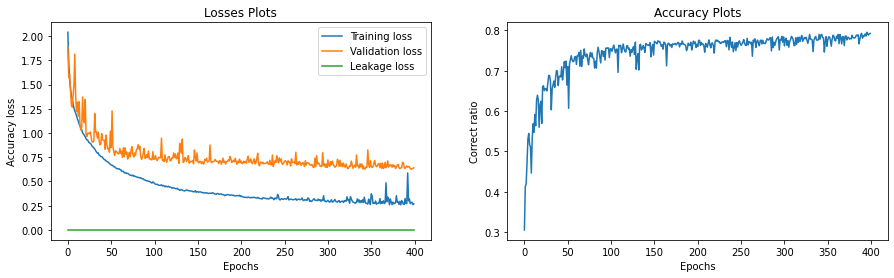

In [12]:
plot_losses()


Test accuracy: 0.7866666666666666


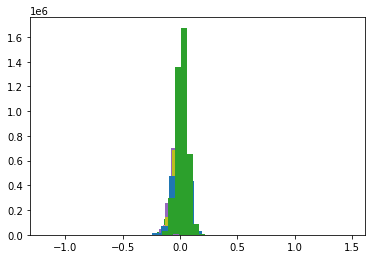

In [13]:
test_model()

##Measuring Privacy Preserving

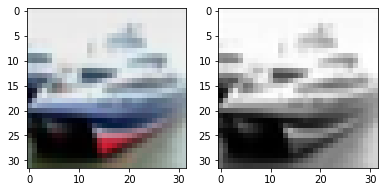

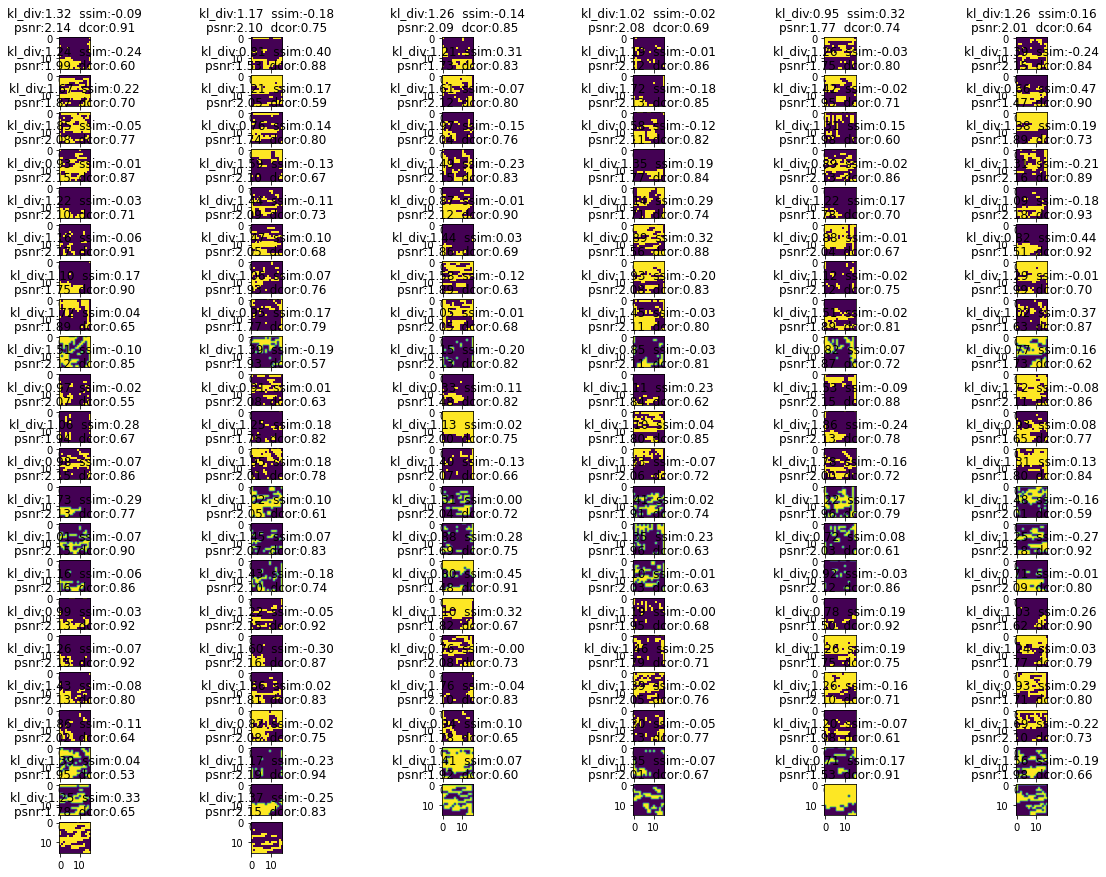

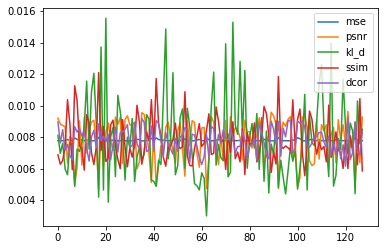

In [14]:
plot_measure(measure_image(testSet[1][0]))


tensor(1.3225, device='cuda:0') 0.783808515168302 tensor(0.1201, device='cuda:0')


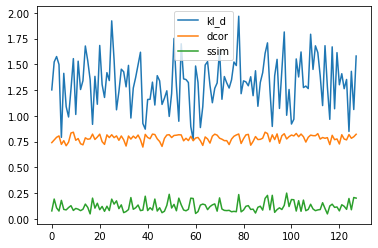

In [15]:
plot_measures(measure_images())